In [ ]:
#default_exp vision.multichannel

# Multi- and Hyperspectral Imaging

> Helpers for working with multi- and hyperspectral images that can't be opened with PIL (such as geotiff `.tif`)

## Features

* Visualizations
    * Depending on channels-parameter, `.show()` visualizes either single channel if `len(channels) == 1`, normalized index if `len(channels) == 2` or RGB-render if `len(channels) == 3`.
* Transforms
    * `ToVolumetric` changes batch of 2d images into 3d images, which means that its possible use image augmentations from `vision.augmentation`
    * `ScaleToFloatTensor` scales images by some factor (usually 10000 for S2-images) without clamping any values. This differentiates it from `IntToFloatTensor`

## Work in progress, TODO

* Visualizations
    * API for holoviews?
    * Option to add default RGB visualization channels for more straightforward visualizations. Also default vmin and vmax values
        * Also visualizing based on input parameters seems non-optimal.
    * Add min/max -metrics for scaling
    * Fix `channels` -parameter for `show_composite` and `show_single_channel` so that segmentation masks show correctly
    * Show normalized spectral indices
    
* Transforms
    * Possibilities to add spectral indices to image stack
        * In the case of SAR-images, the ratio/difference band (depending whether we have DN or DB scale)
    * Check that all transforms work
    * Hyperspectral cutout 
    * Maybe arbitrary rotations in the style of [this](https://github.com/jaeeolma/lulc_ml/blob/master/utils/data_utils.py) -> DataGeneratorImage -> __data_generation

* Splitters
    * Splitter thats based on dataframe column or coordinates -> Spatial crossvalidation

In [ ]:
#export 
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.vision.core import *
from fastai2.vision.data import *
from fastai2.data.all import *
from typing import Tuple
import rasterio as rio
import geopandas as gpd

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
TEST_TIF = 'images/s2_113_p106.tif'
TEST_NPY = 'images/hs_cube.npy'

# MultiChannelTensorImage

In [ ]:
#export

def open_npy(fn, chans=None):
    im = torch.from_numpy(np.load(str(fn)))
    if chans is not None: im = im[chans]
    return im

def open_geotiff(fn, chans=None):
    with rio.open(str(fn)) as f:
        data = f.read()
        data = data.astype(np.float32)
    im = torch.from_numpy(data)
    if chans is not None: im = im[chans]
    return im

class MultiChannelTensorImage(TensorImage):
    _show_args = ArrayImageBase._show_args
    def show(self, channels=[1], ctx=None, vmin=None, vmax=None, **kwargs):
        "These need refactoring maybe"
        if channels == 'spectra':
            return show_mean_spectra(self, ctx=ctx,  **kwargs)
        if len(channels) == 3: 
            return show_composite(self, channels=channels, ctx=ctx, vmin=vmin, vmax=vmax,
                                  **{**self._show_args, **kwargs})
        if len(channels) == 2:
            return show_normalized_spectral_index(self, channels=channels, ctx=ctx,
                                                  **{**self._show_args, **kwargs})
        elif len(channels) == 1: 
            return show_single_channel(self, channel=channels[0], ctx=ctx, 
                                       **{**self._show_args, **kwargs})

    @classmethod
    def create(cls, fn:(Path,str,ndarray), chans=None,  **kwargs) ->None:
        if isinstance(fn, Tensor): fn = fn.numpy()
        if isinstance(fn, ndarray): 
            im = torch.from_numpy(fn)
            if chans is not None: im = im[chans]
            return cls(im)
        if isinstance(fn, Path) or isinstance(fn, str):
            if str(fn).endswith('npy'): return cls(open_npy(fn=fn, chans=chans))
            elif str(fn).endswith('.tif'): return cls(open_geotiff(fn=fn, chans=chans))
        
    def __repr__(self): return f'{self.__class__.__name__} size={"x".join([str(d) for d in self.shape])}'
    
MultiChannelTensorImage.create = Transform(MultiChannelTensorImage.create) 
        
def show_composite(img, channels, ax=None, figsize=(3,3), title=None, scale=True,
                   ctx=None, vmin=None, vmax=None, scale_axis=(0,1), **kwargs)->plt.Axes:
    "Show three channel composite so that channels correspond to R, G and B"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    r, g, b = channels
    tempim = img.data.cpu().numpy()
    im = np.zeros((tempim.shape[1], tempim.shape[2], 3))
    im[...,0] = tempim[r]
    im[...,1] = tempim[g]
    im[...,2] = tempim[b]

    if scale: im = norm(im, vmin, vmax, scale_axis)
    ax.imshow(im, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_single_channel(img, channel, ax=None, figsize=(3,3), ctx=None, 
                        title=None, **kwargs) -> plt.Axes:
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)    
    tempim = img.data.cpu().numpy()
    ax.imshow(norm(tempim[channel], vmin=tempim[channel].min(), vmax=tempim[channel].max()), **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_normalized_spectral_index(img, channels, ax=None, figsize=(3,3), ctx=None,
                                   title=None, **kwargs) -> plt.Axes:
    "Show normalized spectral index such as NDVI"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    b_0, b_1 = channels
    tempim = img.data.cpu().numpy()
    im = (tempim[b_0] - tempim[b_1])/(tempim[b_0] + tempim[b_1])
    ax.imshow(im, vmin=-1, vmax=1, **kwargs)
    ax.axis('off')
    if title is not None: ax.set_title(title)
    return ax

def show_mean_spectra(img, ax=None, figsize=(3,3), ctx=None, title=None, **kwargs) -> plt.Axes:
    "Show average spectra graph"
    ax = ifnone(ax, ctx)
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    tempim = img.data.cpu().numpy()
    means = np.nanmean(tempim, axis=(-2, -1))
    ax.plot(means, **kwargs)
    ax.grid(True)
    if title is not None: ax.set_title(title)
    return ax
        
def norm(vals, vmin=None, vmax=None, axis=(0,1)):
    """
    For visualization purposes scale image with `(vals-vmin)/(vmax-vmin), 
    with vmin and vmax either specified or within 0.01 and 0.99 quantiles of all values
    """
    vmin = ifnone(vmin, np.quantile(vals, 0.01, axis=axis))
    vmax = ifnone(vmax, np.quantile(vals, 0.99, axis=axis))
    ret_im = (vals - vmin)/(vmax-vmin)
    ret_im[ret_im < 0] = 0
    ret_im[ret_im > 1] = 1
    return ret_im

Base class and visualization functions

Test for .npy -files and 3D images

In [ ]:
npy_img = MultiChannelTensorImage.create(TEST_NPY)
npy_img

MultiChannelTensorImage size=461x17x17

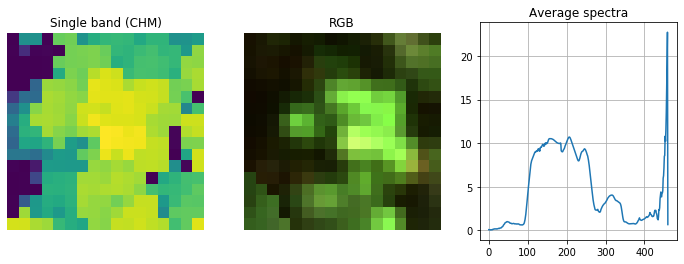

In [ ]:
_, ax = plt.subplots(1,3, figsize=(12,4))
npy_img.show(channels=[-1], ax=ax[0], title='Single band (CHM)')
npy_img.show(channels=(82,50,29), ax=ax[1], title='RGB', scale=True, scale_axis=None)
npy_img.show(channels='spectra', ax=ax[2], title='Average spectra')
plt.show()

In case you are wondering, this is 0.5m ground resolution image centered to a single treetop. Average spectra looks stupid because last channel is normalized height instead of spectral channel

Test for geotiffs

In [ ]:
tif_img = MultiChannelTensorImage.create(TEST_TIF)
tif_img

MultiChannelTensorImage size=13x256x256

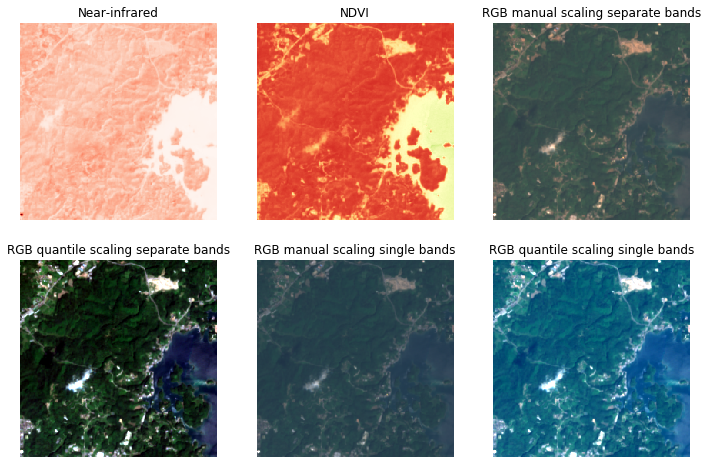

In [ ]:
_, ax = plt.subplots(2,3, figsize=(12,8))
tif_img.show(channels=[7], ax=ax[0,0], figsize=(6,6), title='Near-infrared', cmap='Reds')
tif_img.show(channels=(7,3), ax=ax[0,1], title='NDVI', figsize=(6,6), cmap='RdYlGn_r')
tif_img.show(channels=(3,2,1), ax=ax[0,2], title='RGB manual scaling separate bands', figsize=(6,6), scale=True, 
             vmin=np.array([0,0,0]), vmax=np.array([2000,2500,3000]))
tif_img.show(channels=(3,2,1), ax=ax[1,0], title='RGB quantile scaling separate bands', figsize=(6,6), scale=True)
tif_img.show(channels=(3,2,1), ax=ax[1,1], title='RGB manual scaling single bands', figsize=(6,6), scale=True, 
             vmin=np.array([0]), vmax=np.array([3000]), scale_axis=None)
tif_img.show(channels=(3,2,1), ax=ax[1,2], title='RGB quantile scaling single bands', figsize=(6,6), scale=True,
             scale_axis=None)

This image is from [SEN12MS dataset](https://mediatum.ub.tum.de/1474000)

## MultiChannelImageBlock

In [ ]:
#export
def MultiChannelImageBlock(cls=MultiChannelTensorImage, chans=None): 
    "Default behaviour: use all channels"
    return TransformBlock(partial(cls.create, chans=chans))

In [ ]:
npy = DataBlock(blocks=(MultiChannelImageBlock(chans=None)), 
                get_items=partial(get_files, extensions='.npy'), splitter=None)
dset = npy.datasets(source='images/')
dset

(#1) [(MultiChannelTensorImage size=461x17x17,)]

In [ ]:
dls = npy.dataloaders(source='images', bs=1)

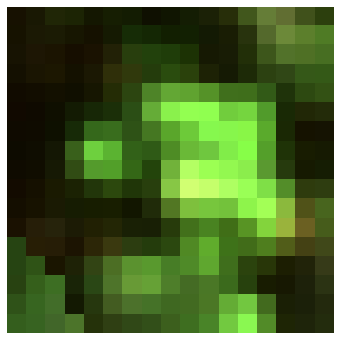

In [ ]:
dls.show_batch(channels=(82,50,29), figsize=(6,6), scale_axis=None)

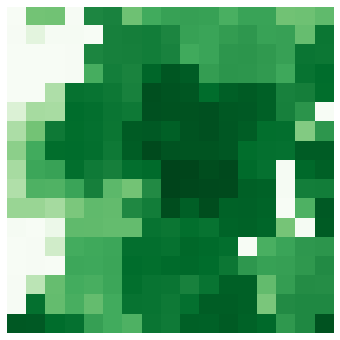

In [ ]:
dls.show_batch(channels=[-1], figsize=(6,6), cmap='Greens')

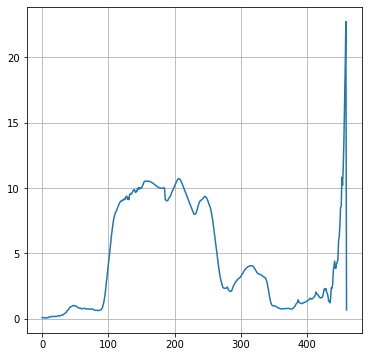

In [ ]:
dls.show_batch(channels='spectra', figsize=(6,6))

In [ ]:
tif = DataBlock(blocks=(MultiChannelImageBlock()), get_items=partial(get_files, extensions='.tif', recurse=False), splitter=None)

In [ ]:
tif_dls = tif.dataloaders(source='images', bs=1)
tif_dls.items

[Path('images/s2_113_p106.tif')]

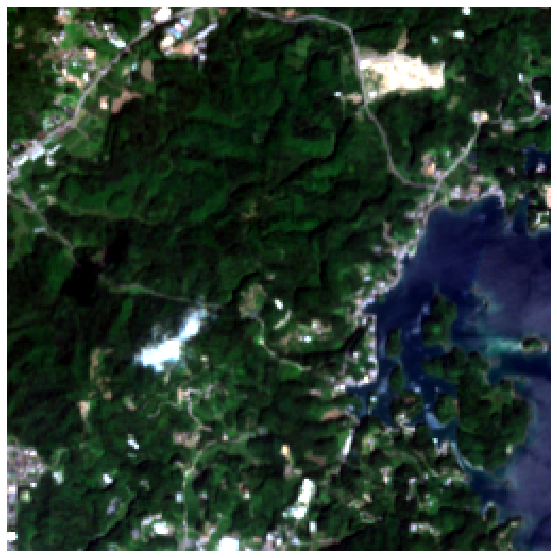

In [ ]:
ctxs = tif_dls.show_batch(channels=(3,2,1), figsize=(10,10), scale=True)

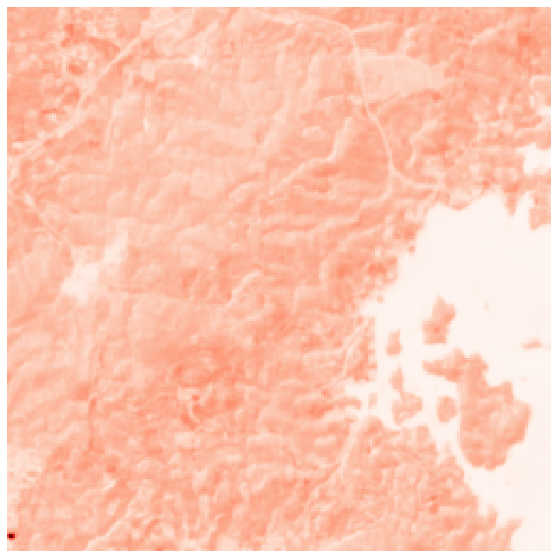

In [ ]:
ctxs = tif_dls.show_batch(channels=(7,), figsize=(10,10), cmap='Reds')

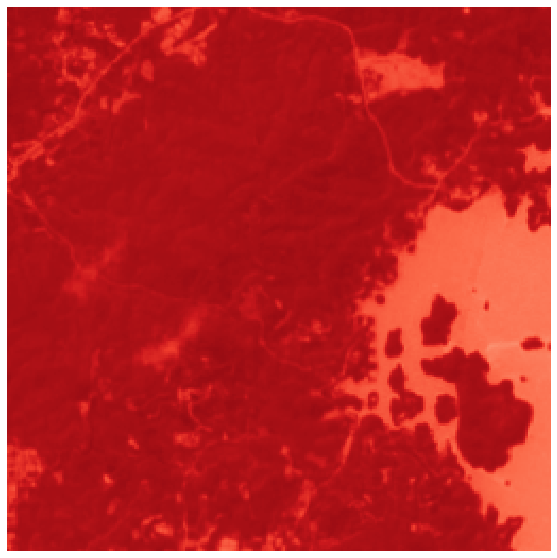

In [ ]:
ctxs = tif_dls.show_batch(channels=(7,3), figsize=(10,10), cmap='Reds')

## MultiChannelImageDataLoaders

In [ ]:
#export
def _using_attr(f, attr, x):
    return f(getattr(x,attr))

In [ ]:
#export
def using_attr(f, attr):
    "Change function `f` to operate on `attr`"
    return partial(_using_attr, f, attr)

In [ ]:
#export

class MultiChannelImageDataLoaders(DataLoaders):
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, chans=None, extensions=['.tif'], 
                    train='train', valid='valid', valid_pct=None, seed=None, 
                    vocab=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from imagenet style dataset in `path` with `train`, `valid`, `test` subfolders (or provide `valid_pct`).
        Optionally list the channels to use."""
        splitter = GrandparentSplitter(train_name=train, valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct, seed=seed)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           get_items=partial(get_files, extensions=extensions),
                           splitter=splitter,
                           get_y=parent_label,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_path_func(cls, path, fnames, label_func,chans=None, extensions=['.tif'], 
                       valid_pct=0.2, seed=None, item_tfms=None, batch_tfms=None, **kwargs):
        """Create from list of `fnames` in `path`s with `label_func`.   
        Optionally list the channels to use."""

        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), CategoryBlock(vocab=vocab)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, path, path=path, **kwargs)
    
    @classmethod
    def from_name_func(cls, path, fnames, label_func, 
                       chans=None, extensions=['.tif'], **kwargs):
        """Create from name attrs in list of `fnames` in `path`s with `label_func`.
        Optionally list the channels to use."""
        f = using_attr(label_func, 'name')
        return cls.from_path_func(path, fnames, f, chans=chans, **kwargs)

    @classmethod
    def from_path_re(cls, path, fnames, pat, chans=None, extensions=['.tif'], **kwargs):
        """Create from list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use."""
        return cls.from_path_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_name_re(cls, path, fnames, pat, chans=None, extensions=['.tif'],**kwargs):
        """Create from name attrs in list of `fnames` in `path`s with re expression `pat`.
           Optionally list the channels to use"""
        return cls.from_name_func(path, fnames, RegexLabeller(pat), chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_df(cls, df, path='.', chans=None, valid_pct=0.2, seed=None, 
                fn_col=0, folder=None, suff='', label_col=1, label_delim=None,
                y_block=None, valid_col=None, item_tfms=None, batch_tfms=None, **kwargs):
        pref = f'{Path(path) if folder is None else Path(path)/folder}{os.path.sep}'
        if y_block is None:
            is_multi = (is_listy(label_col) and len(label_col) > 1) or label_delim is not None
            y_block = MultiCategoryBlock if is_multi else CategoryBlock
        splitter = RandomSplitter(valid_pct, seed=seed) if valid_col is None else ColSplitter(valid_col)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), y_block),
                           get_x=ColReader(fn_col, pref=pref, suff=suff),
                           get_y=ColReader(label_col, label_delim=label_delim),
                           splitter=splitter,
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, df, path=path, **kwargs)

    @classmethod
    def from_shapefile(cls, path, chans=None, shp_fname='labels.shp', **kwargs):
        """Create from shapefile `shp_fname` in `path` readable with geopandas.
        Optionally list the channels to use."""
        df = gpd.read_file(str(Path(path)/shp_fname))
        # Shapefiles don't support boolean columns
        if 'valid_col' in kwargs.keys(): df[kwargs['valid_col']] = df[kwargs['valid_col']].astype(bool)
        return cls.from_df(df, path=path, chans=chans, **kwargs)
    
    @classmethod
    def from_csv(cls, path,  chans=None, csv_fname='labels.csv', 
                 header='infer', delimiter=None, **kwargs):
        df = pd.read_csv(Path(path)/csv_fname, header=header, delimiter=delimiter)
        return cls.from_df(df, path=path, chans=chans, **kwargs)

    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_lists(cls, path, fnames, labels,chans=None, valid_pct=0.2, 
                   seed:int=None, y_block=None, item_tfms=None, batch_tfms=None,
                   **kwargs):
        """Create from list of `fnames` in `path`. Specify dims to be either 2 (for 2d images) or 3 (for volumetric images)
        and optionally list the channels to use."""
        if y_block is None:
            y_block = MultiCategoryBlock if is_listy(labels[0]) and len(labels[0]) > 1 else (
                RegressionBlock if isinstance(labels[0], float) else CategoryBlock)
        dblock = DataBlock(blocks=(MultiChannelImageBlock(dims=dims, chans=chans), y_block),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           item_tfms=item_tfms, 
                           batch_tfms=batch_tfms)
        return cls.from_dblock(dblock, (fnames, labels), path=path, **kwargs)
    
MultiChannelImageDataLoaders.from_csv = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_csv)
MultiChannelImageDataLoaders.from_shapefile = delegates(to=MultiChannelImageDataLoaders.from_df)(MultiChannelImageDataLoaders.from_shapefile)
MultiChannelImageDataLoaders.from_name_func = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_name_func)
MultiChannelImageDataLoaders.from_path_re = delegates(to=MultiChannelImageDataLoaders.from_path_func)(MultiChannelImageDataLoaders.from_path_re)
MultiChannelImageDataLoaders.from_name_re = delegates(to=MultiChannelImageDataLoaders.from_name_func)(MultiChannelImageDataLoaders.from_name_re)

In [ ]:
npy_dls = MultiChannelImageDataLoaders.from_folder(path=Path('images/'),chans=None, 
                                                   extensions=['.npy'], valid_pct=0, bs=1)

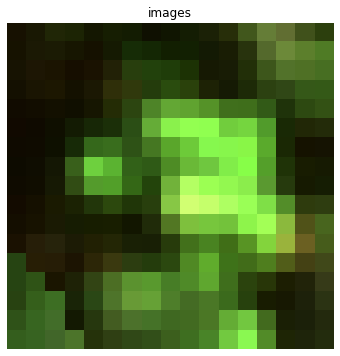

In [ ]:
npy_dls.show_batch(channels=(82,50,29), figsize=(6,6), scale_axis=None)

In [ ]:
show_doc(MultiChannelImageDataLoaders.from_folder)

<h4 id="MultiChannelImageDataLoaders.from_folder" class="doc_header"><code>MultiChannelImageDataLoaders.from_folder</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>MultiChannelImageDataLoaders.from_folder</code>(**`path`**, **`chans`**=*`None`*, **`extensions`**=*`['.tif']`*, **`train`**=*`'train'`*, **`valid`**=*`'valid'`*, **`valid_pct`**=*`None`*, **`seed`**=*`None`*, **`vocab`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from imagenet style dataset in `path` with `train`, `valid`, `test` subfolders (or provide `valid_pct`).
Optionally list the channels to use.

In [ ]:
show_doc(MultiChannelImageDataLoaders.from_shapefile)

<h4 id="MultiChannelImageDataLoaders.from_shapefile" class="doc_header"><code>MultiChannelImageDataLoaders.from_shapefile</code><a href="__main__.py#L73" class="source_link" style="float:right">[source]</a></h4>

> <code>MultiChannelImageDataLoaders.from_shapefile</code>(**`path`**, **`chans`**=*`None`*, **`shp_fname`**=*`'labels.shp'`*, **`valid_pct`**=*`0.2`*, **`seed`**=*`None`*, **`fn_col`**=*`0`*, **`folder`**=*`None`*, **`suff`**=*`''`*, **`label_col`**=*`1`*, **`label_delim`**=*`None`*, **`y_block`**=*`None`*, **`valid_col`**=*`None`*, **`item_tfms`**=*`None`*, **`batch_tfms`**=*`None`*, **`bs`**=*`64`*, **`val_bs`**=*`None`*, **`shuffle_train`**=*`True`*, **`device`**=*`None`*)

Create from shapefile `shp_fname` in `path` readable with geopandas.
Optionally list the channels to use.

In [ ]:
shp = gpd.read_file('../../hs_data/4m/train.shp').drop(columns=['geometry'])
shp.head()

,X,Y,Height_m,CA_m2,ttop_x,ttop_y,bounds_x,bounds_y,tile_id,meas_x,meas_y,species,dbh,sum_2019,nov_2019,is_gps,filename,bbox_area,label_id
0,398556.03,6790571.70,29.34,10.38,398555.75,6790571.25,3.50,3.75,R10C12,398556.921198,6.790572e+06,Norway spruce,414.0,0.0,0.0,0.0,8.npy,13.1250,2
1,398558.63,6790564.63,25.69,8.12,398558.75,6790564.75,2.50,4.00,R10C12,398558.443603,6.790563e+06,Norway spruce,268.0,0.0,0.0,0.0,9.npy,10.0000,2
2,398706.76,6790396.97,19.61,11.12,398706.75,6790397.25,3.75,3.50,R10C12,398708.284670,6.790397e+06,Scots pine,198.0,0.0,0.0,0.0,10.npy,13.1250,1
3,398707.69,6790393.32,19.69,10.00,398708.25,6790393.25,3.00,4.00,R10C12,398707.679471,6.790395e+06,Scots pine,198.0,0.0,0.0,0.0,11.npy,12.0000,1
4,398715.83,6790389.06,19.55,5.56,398715.75,6790389.25,2.25,3.25,R10C12,398715.383956,6.790390e+06,Scots pine,202.0,0.0,0.0,0.0,12.npy,7.3125,1


For some reasons `Dihedral` doesn't work with 3d data but `DihedralItem` does.

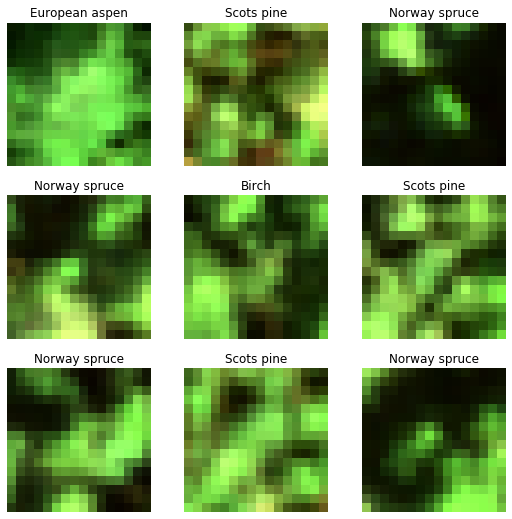

In [ ]:
stats = np.load('../../hs_data/4m/train_stats.npy')


test_geodf = MultiChannelImageDataLoaders.from_shapefile('../../hs_data/4m/', shp_fname='train.shp', chans=list(range(460)),
                                                         extensions=['.npy'], label_col='species', fn_col='filename',
                                                         bs=32, batch_tfms=[
                                                             Normalize.from_stats(*stats[:,:-1]),
                                                         ])
test_geodf.show_batch(channels=[82,50,29], scale=True, scale_axis=None)

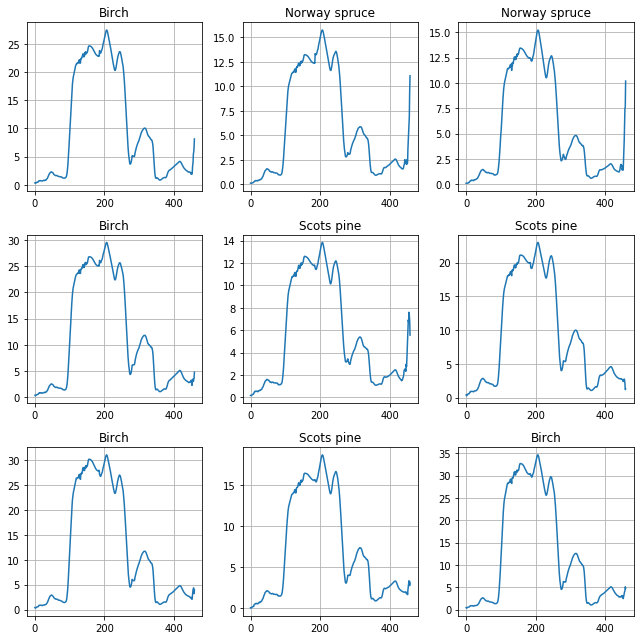

In [ ]:
test_geodf.show_batch(channels='spectra')
plt.tight_layout()

These trees have labels so we can show them

In [ ]:
batch = test_geodf.one_batch()
batch

(MultiChannelTensorImage size=32x460x16x16,
 TensorCategory([3, 3, 0, 3, 2, 3, 3, 0, 2, 3, 2, 3, 3, 1, 3, 2, 3, 0, 1, 3, 2, 1, 3, 1,
         2, 3, 1, 0, 2, 3, 2, 2]))

## Segmentation tasks
> Again due to PIL limitations we need custom solutions for geotiff raster masks


Work in progress, problems with `show_batch`

In [ ]:
type(dls.train)

fastai2.data.core.TfmdDL

In [ ]:
def get_mask_from_tif(fn):
    return open_geotiff(fn, chans=[0])[0] - 1

In [ ]:
#export
class TifSegmentationDataLoaders(DataLoaders):
    "Needs a better name"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_funcs(cls, path, fnames, label_func, chans=None, 
                         extensions=['.tif'], valid_pct=0.2, seed=None, 
                         codes=None, item_tfms=None, batch_tfms=None, **kwargs):
        "Create from list of `fnames` in `path`s with `label_func`."
        dblock = DataBlock(blocks=(MultiChannelImageBlock(chans=chans), 
                                   MaskBlock(codes=codes)),
                           splitter=RandomSplitter(valid_pct, seed=seed),
                           get_y=label_func,
                           item_tfms=item_tfms,
                           batch_tfms=batch_tfms)
        res = cls.from_dblock(dblock, fnames, path=path, **kwargs)
        return res

In [ ]:
segm = TifSegmentationDataLoaders.from_label_funcs(path='images/', bs=1, codes=list(range(0,17)),
                                                   fnames=get_files('images/', extensions=['.tif'], recurse=False),
                                                   label_func = lambda o: get_mask_from_tif(f'images/masks/{o.stem}{o.suffix}'))

In [ ]:
segm.one_batch()

(MultiChannelTensorImage size=1x13x256x256,
 TensorMask([[[ 8,  8,  8,  ...,  1,  1,  1],
          [ 8,  8,  8,  ...,  1,  1,  1],
          [ 8,  8,  8,  ...,  1,  1,  1],
          ...,
          [ 7,  7,  7,  ..., 16, 16, 16],
          [ 7,  7,  7,  ..., 16, 16, 16],
          [ 7,  7,  7,  ..., 16, 16, 16]]]))

Test that `unet_learner` works. Not interested whether it manages to produce anything sensible but just that it works.

In [ ]:
learn = unet_learner(segm, resnet34, n_in=13, pretrained=False)


In [ ]:
learn.fit_one_cycle(10, lr_max=1e-3)

epoch,train_loss,valid_loss,time
0,5.527469,None,00:05
1,5.168191,None,00:05
2,6.343024,None,00:05
3,5.389436,None,00:05
4,4.700356,None,00:05
5,4.188271,None,00:05
6,3.794636,None,00:05
7,3.474260,None,00:05
8,3.213419,None,00:05
9,3.005249,None,00:05


/home/mayrajeo/miniconda3/envs/fastai2/lib/python3.7/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [ ]:
pred = learn.predict(MultiChannelTensorImage.create(TEST_TIF))

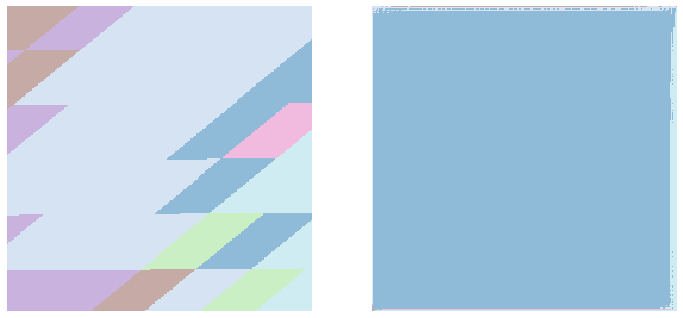

In [ ]:
_, ax = plt.subplots(1,2, figsize=(12,6))
segm.one_batch()[1].show(vmin=0, vmax=16, ax=ax[0])
pred[0].show(vmin=0, vmax=16, ax=ax[1])

# Transforms

In [ ]:
def _batch_ex(bs, timg, maxval): return MultiChannelTensorImage((timg/maxval)[None].expand(bs, *timg.shape).clone())

## ScaleToFloatTensor

In [ ]:
#export

class ScaleToFloatTensor(Transform):
    "Scale image values to interval 0-1"
    order = 10
    
    def __init__(self, div=100., div_mask=1, split_idx=None):
        super().__init__(split_idx=split_idx)
        self.div, self.div_mask = div, div_mask
        
    def encodes(self, o:TensorImage): return o.float().div_(self.div)
    def decodes(self, o:TensorImage): return o * self.div if self.div else o

In [ ]:
tfm_hs = ScaleToFloatTensor(div=100)
ft = tfm_hs(npy_img.clone())
test_eq(ft, npy_img/100)
test_eq(type(ft), MultiChannelTensorImage)
test_eq(ft.type(), 'torch.FloatTensor')

In [ ]:
tfm_s2 = ScaleToFloatTensor(div=10000)
ft = tfm_s2(tif_img.clone())
test_eq(ft, tif_img/10000)
test_eq(type(ft), MultiChannelTensorImage)
test_eq(ft.type(), 'torch.FloatTensor')

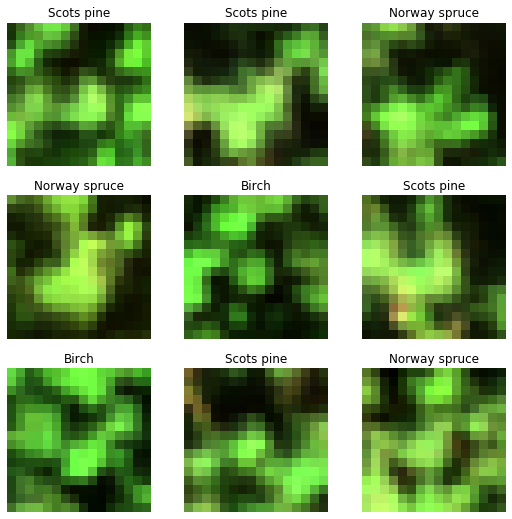

In [ ]:
test_geodf = MultiChannelImageDataLoaders.from_shapefile('../../hs_data/4m/', shp_fname='train.shp', 
                                                         extensions=['.npy'], label_col='species', fn_col='filename',
                                                         bs=16, batch_tfms=[
                                                             Normalize.from_stats(*stats / 100),                                                    
                                                         ], 
                                                         item_tfms=[ScaleToFloatTensor(div=100)])
test_geodf.show_batch(channels=[82,49,28], scale=True, scale_axis=None)

## ToVolumetric

In [ ]:
#export

class ToVolumetric(Transform):
    "Transforms batch of  2D images to 3D images"
    order = 99
    
    def __init__(self, split_idx=None):
        super().__init__(split_idx=split_idx)
        
    def encodes(self, o:TensorImage):  
         return o[:,None]
    def decodes(self, o:TensorImage): 
         return o[:,0]

In [ ]:
test_batch = _batch_ex(1, npy_img, 100)
tfm_hs = ToVolumetric()
ft = tfm_hs(test_batch)
test_eq(ft[0].shape, test_batch.shape)
test_eq(type(ft), MultiChannelTensorImage)
test_eq(ft.type(), 'torch.FloatTensor')

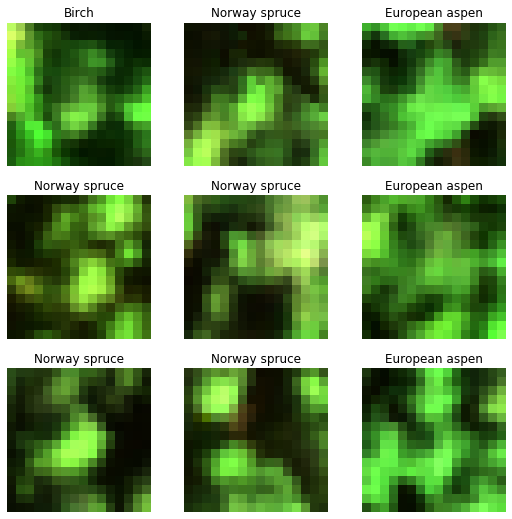

In [ ]:
test_geodf = MultiChannelImageDataLoaders.from_shapefile('../../hs_data/4m/', shp_fname='train.shp', 
                                                         extensions=['.npy'], label_col='species', fn_col='filename',
                                                         bs=16, batch_tfms=[
                                                             Normalize.from_stats(*stats / 100),
                                                             ToVolumetric()
                                                         ], 
                                                         item_tfms=[ScaleToFloatTensor(div=100)])
test_geodf.show_batch(channels=[82,49,28], scale=True, scale_axis=None)

In [ ]:
test_geodf.one_batch()

(MultiChannelTensorImage size=16x1x461x16x16,
 TensorCategory([3, 3, 0, 0, 3, 1, 3, 0, 3, 0, 3, 1, 1, 3, 3, 3]))

Now seems to be a good time to test that we really can select bands

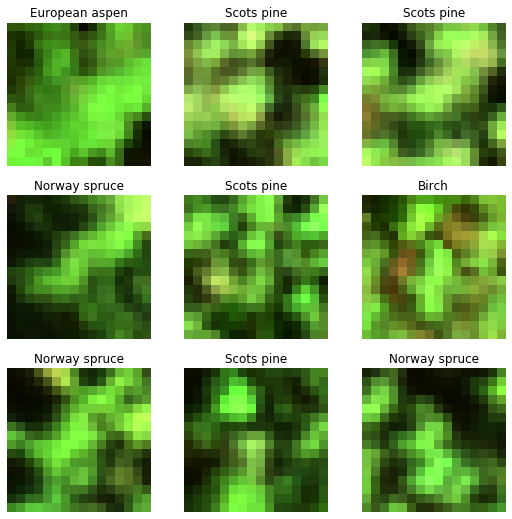

In [ ]:
test_geodf = MultiChannelImageDataLoaders.from_shapefile('../../hs_data/4m/', shp_fname='train.shp', chans=list(range(180)),
                                                         extensions=['.npy'], label_col='species', fn_col='filename',
                                                         bs=16, batch_tfms=[
                                                             Normalize.from_stats(*stats[:,180] / 100),
                                                             ToVolumetric()
                                                         ], 
                                                         item_tfms=[ScaleToFloatTensor(div=100)])
test_geodf.show_batch(channels=[82,49,28], scale=True, scale_axis=None)

In [ ]:
test_geodf.one_batch()

(MultiChannelTensorImage size=16x1x180x16x16,
 TensorCategory([2, 2, 3, 0, 3, 3, 2, 0, 3, 3, 3, 3, 3, 0, 2, 3]))

## AddSpectralIndices

> Work in progress, how to add spectral indices to image stacks while loading. Problem: Normalization

In [ ]:
#export

# Data augmentation
> Checks for augmentations

## Test dihedral flips

In [ ]:
npy_img = MultiChannelTensorImage.create(TEST_NPY, chans=list(range(460)))
npy_img

MultiChannelTensorImage size=460x17x17

In [ ]:
for k in range(0,8):
    print(npy_img.dihedral(k).shape)

torch.Size([460, 17, 17])
torch.Size([460, 17, 17])
torch.Size([460, 17, 17])
torch.Size([460, 17, 17])
torch.Size([460, 17, 17])
torch.Size([460, 17, 17])
torch.Size([460, 17, 17])
torch.Size([460, 17, 17])


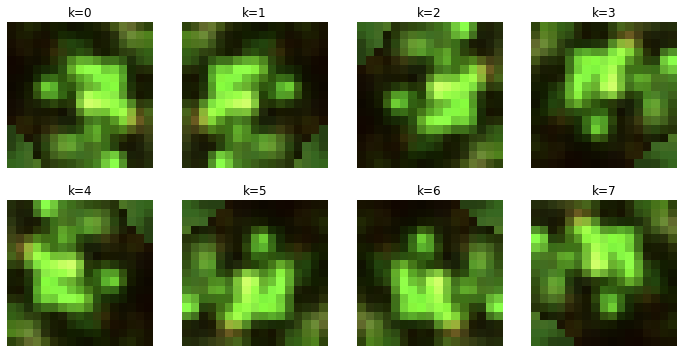

In [ ]:
_,axs = subplots(2, 4)
for k, ax in zip(range(0,8),axs.flatten()):
    npy_img.dihedral(k).show(channels=(82, 49, 28), ax=ax,  title=f'k={k}', scale_axis=None)

Check that DihedralItem works

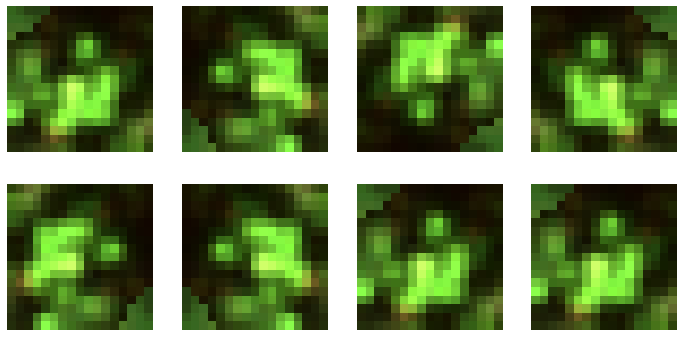

In [ ]:
_,axs = subplots(2, 4)
for ax in axs.flatten():
    show_composite(DihedralItem(p=1.)(npy_img, split_idx=0), ctx=ax, channels=(82,49,28), scale_axis=None)

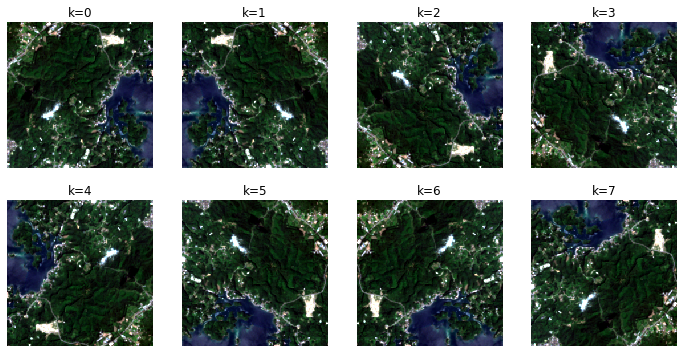

In [ ]:
_,axs = subplots(2, 4)
for k, ax in zip(range(0,8),axs.flatten()):
    tif_img.dihedral(k).show((3,2,1), ax=ax, title=f'k={k}')

## Test lighting transforms


In [ ]:
npy_vals = npy_img.data.cpu().numpy()[[82,50,29]] / 100
npy_vmin = np.quantile(npy_vals, 0.000, axis=None)
npy_vmax = np.quantile(npy_vals, 1, axis=None)

In [ ]:
npy_vmin * 100, npy_vmax * 100

(0.009953376866178587, 3.53747121989727)

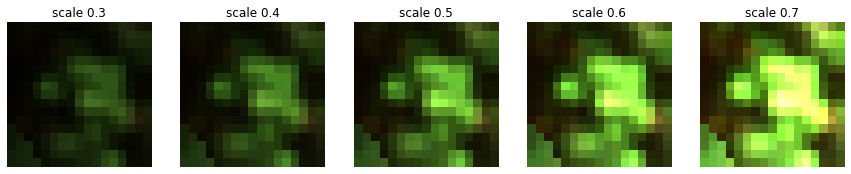

In [ ]:
scales = [0.3, 0.4, 0.5, 0.6, 0.7]
y = _batch_ex(5, npy_img, 100).brightness(draw=scales, p=1.)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_composite(y[i], channels=(82,49,28), ctx=ax, title=f'scale {scales[i]}', scale=True, 
                   vmin=npy_vmin, vmax=npy_vmax, scale_axis=None)

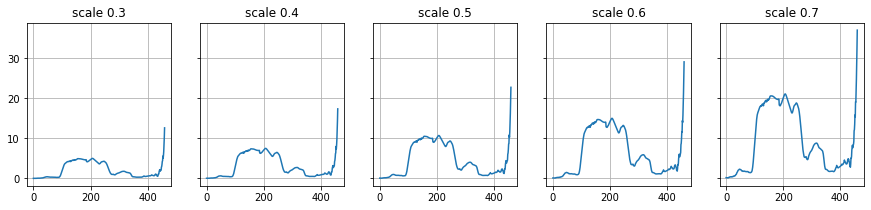

In [ ]:
scales = [0.3, 0.4, 0.5, 0.6, 0.7]
y = _batch_ex(5, npy_img, 100).brightness(draw=scales, p=1.)
fig,axs = plt.subplots(1,5, figsize=(15,3), sharey=True)
for i,ax in enumerate(axs.flatten()):
    show_mean_spectra(y[i]*100, ctx=ax, title=f'scale {scales[i]}')

Same for 2D-images

In [ ]:
tif_vals = tif_img.data.cpu().numpy()[[3,2,1]]/10000
tif_vmin = np.quantile(tif_vals, 0.01, axis=(1,2))
tif_vmax = np.quantile(tif_vals, 0.99, axis=(1,2))

In [ ]:
scales = [0.4, 0.45, 0.5, 0.55, 0.6]
y = _batch_ex(5, tif_img, 10000).brightness(draw=scales, p=1.)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_composite(y[i], channels=(3,2,1), ctx=ax, title=f'scale {scales[i]}', scale=True, vmin=tif_vmin, vmax=tif_vmax)

## Test contrast

Not really sure how useful this is but still lets see if it works.

In [ ]:
scales = [0.65, 0.8, 1., 1.25, 1.55]
y = _batch_ex(5, npy_img, 100).contrast(draw=scales, p=1.)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_composite(y[i], channels=(82,49,28), ctx=ax, title=f'scale {scales[i]}', scale=True)#, vmin=npy_vmin, vmax=npy_vmax)

In [ ]:
scales = [0.65, 0.8, 1., 1.25, 1.55]
y = _batch_ex(5, tif_img, 10000).contrast(draw=scales, p=1.)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_composite(y[i], channels=(3,2,1), ctx=ax, title=f'scale {scales[i]}', scale=True)#, vmin=tif_vmin, vmax=tif_vmax)

## Test Random erasing / Cutout

In [ ]:
nrm = Normalize.from_stats(*stats, cuda=False)

In [ ]:
f = partial(cutout_gaussian, areas=[(2,6,2,6),(10,12,10,14)])

In [ ]:
show_composite(norm_apply_denorm(npy_img.clone()/100, f, nrm)[0], channels=(82,49,28), scale=True, 
               vmin=npy_vmin, vmax=npy_vmax)

In [ ]:
scales = [0.3, 0.4, 0.5, 0.6, 0.7]
y = _batch_ex(5, npy_img, 100)
f = partial(RandomErasing(p=1., max_count=2), split_idx=0)
fig,axs = plt.subplots(1,5, figsize=(15,3))
for i,ax in enumerate(axs.flatten()):
    show_composite(norm_apply_denorm(y,f,nrm)[0], channels=(82,49,28), ctx=ax, scale=True, 
                   vmin=npy_vmin, vmax=npy_vmax)

## Test multiple together with dataloaders

In [ ]:
test_geodf = MultiChannelImageDataLoaders.from_shapefile('../../hs_data/4m/', shp_fname='train.shp', 
                                                         extensions=['.npy'], label_col='species', fn_col='filename',
                                                         bs=16, batch_tfms=[
                                                             Normalize.from_stats(*stats / 100),
                                                             ToVolumetric(),
                                                             Dihedral(),
                                                             Brightness(max_lighting=0.1),
                                                             Contrast(max_lighting=0.1),
                                                             RandomErasing()
                                                         ], 
                                                         item_tfms=[ScaleToFloatTensor(div=100)])
test_geodf.show_batch(channels=[82,50,28], scale=True, vmin=npy_vmin*100, vmax=npy_vmax*100, scale_axis=None)

In [ ]:
test_geodf.one_batch()

# Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destination and was ignored:
e
This cell doesn't have an export destina